<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Value%20Based/DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
import os
import imageio
import random
from matplotlib import pyplot as plt
from itertools import count
import PIL.ImageDraw as ImageDraw
from PIL import Image as Im
from IPython import display
import matplotlib.pyplot as plt

# Q Network

In this section, we create a fully connected neural network which will approximate the Q function. Given a batch of states as input, it outputs a batch of Q-values. Each Q-value represents the return we can expect when we take a particular action in the given state.

In [2]:
class QNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(QNetwork, self).__init__()
    self.activation_fc = activation_fc
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    x = self.output_layer(x)
    return x

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, rewards, new_states, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, rewards, new_states, is_terminals

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Replay Buffer

The replay buffer is a data structure that allows us to implement a technique called **experience replay**. It holds experience samples for several timesteps so that we can sample mini-batches of experiences.

The main benefit of using a replay buffer: the samples (experiences) we pass to the network appear independent and identically distributed which in turn stabilize the optimization process.

The idea behind experience replay is very straightforward:
During training, we collect experiences and store them into the replay buffer. After enough experiences are collected, we then sample a mini-batch of a certain size from the buffer and pass it to the network.

In [3]:
class ReplayBuffer():

  # our replay buffer has a default max size of 50000 and uses a batch size of 64
  def __init__(self, max_size=10000,
               batch_size=64):

    # initialize five empty NumPy arrays that will hold states, actions, rewards, next_states and done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0
    self.size = 0

  def store(self, experience):
    '''
    Store the components of the experience into the corresponding NumPy array.
    '''
    # unwrap the experience which is just a tuple
    s, a, r, p, d = experience

    # store each component to its corresponding NumPy array
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    # adjust the index
    self._idx += 1

    # if the replay buffer is full, we wrap around and overwrite older experiences with new ones
    self._idx = self._idx % self.max_size

    # adjust the size
    self.size += 1
    # determine the size
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    '''
    Sample a mini-batch of experiences from the replay buffer.
    '''
    if batch_size == None:
      batch_size = self.batch_size

    # Generate a uniform random sample from np.arange(self.size) of size 'batch_size' without replacement:
    idxs = np.random.choice(self.size, batch_size, replace=False)

    # create the mini-batch of experiences
    mini_batch_experiences = np.vstack(self.ss_mem[idxs]), \
                             np.vstack(self.as_mem[idxs]), \
                             np.vstack(self.rs_mem[idxs]), \
                             np.vstack(self.ps_mem[idxs]), \
                             np.vstack(self.ds_mem[idxs])

    return mini_batch_experiences

  def __len__(self):
    return self.size

# Exploration strategies

The GreedyStrategy will always select the maximum Q-value.

In [4]:
# the strategy we will use in the evaluation phase
class GreedyStrategy():
  def __init__(self):
    self.exploratory_action_taken = False

  def select_action(self, model, state):
    with torch.no_grad():
      # get the q-value of each action given the state
      q_values = model(state).cpu().detach().data.numpy().squeeze()

      # return the index of the action with the highest estimate
      return np.argmax(q_values)

The exponential $\epsilon$-greedy strategy a decaying epsilon value so that the probability of exploration is higher at the beginning and the probability of exploitation is higher at the end of the training phase.

In [5]:
# the strategy we will use in the training phase
class EGreedyExpStrategy():
  '''
  In the exponentially decaying strategy, the epsilon value is decaying in an exponential curve.
  '''

  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1

    return self.epsilon

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    # we draw the random number from a uniform distribution and compare it to epsilon
    # if it is higher, we use the argmax of the q-values
    # otherwise, we use a random action
    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    # adjust the epsilon value
    self._epsilon_update()

    return action

# DDQN


DDQN stands for "double deep Q-network" and it is an improvement to the DQN algorithm since it mitigates the overestimation of action-value functions.

Recall that the DQN algorithm uses the off-policy TD target with the max operator. The problem is: it takes the max of estimated values. But estimated values can be off-center (meaning that they can be higher/lower than the true values).

The solution DDQN offers to this problem is very simple: we will use the online network to find out the index of the highest-valued action & then ask the target network to tell us the action-value of that action. Basically, the online network is used for action selection and the target network is used for action evaluation. By using the target network for value estimates, we make sure the target values are frozen as needed for stability (like we did in DQN).

All in all, the steps we used in DQN such as interaction step, update step etc. remain the same.
We only need to change the optimization step as you can see below.

At the optimization step, we optimize the model using the following formula:

$\nabla_{\theta_{i}} L_{i} (\theta_{i}) = \mathbb{E}_{\underbrace{(s,a,r,s') \sim U(D)}_\text{sampling of experiences}}[\underbrace{(r+\gamma Q(s', argmax_{a'} Q(s', a'; \theta_{i}); \theta^-}_\text{Target}) - \underbrace{Q(s,a; \theta_{i})}_\text{Prediction}) \nabla_{\theta_{i}} Q(s, a; \theta_{i})]$

An in-depth explanation of the formula:

*   $\mathbb{E}_{(s,a,r,s') \sim U(D)}$

    we use the expectations of the experience tuples; we obtain the experiences we use for training by sampling uniformly at random the replay buffer D

*   $r$

    the experienced reward we get when we take a particular action $a$ in state $s$

*   $\gamma Q(s', argmax_{a'} Q(s', a'; \theta_{i}); \theta^-))$

    This part is different from the DQN formula.
    Here, we first ask the online network to tell us the index of the highest-valued action in the next state.
    Then, we use that index to obtain the corresponding Q-value from the target network.
    So, the index is coming from the online network but the Q-value is coming from the target network.
    As usual, we discount that Q-value with gamma.
    Together with $r$, this part forms the target.

*   $Q(s,a; \theta_{i})$

    The current Q-value estimates are our predictions
    (just like in DQN)






In [6]:
class DDQN():
  def __init__(self,
               env,
               seed,
               online_model,
               target_model,
               replay_buffer,
               optimizer,
               training_strategy,
               evaluation_strategy,
               max_gradient_norm,
               gamma,
               update_steps,
               max_episodes,
               goal,
               warmup_batches):

    # set the attributes
    self.env = env
    self.seed = seed
    self.online_model = online_model
    self.target_model = target_model
    self.replay_buffer = replay_buffer
    self.optimizer = optimizer
    self.training_strategy = training_strategy
    self.evaluation_strategy = evaluation_strategy
    self.max_gradient_norm = max_gradient_norm
    self.gamma = gamma
    self.update_steps = update_steps
    self.max_episodes = max_episodes
    self.goal = goal
    self.warmup_batches = warmup_batches
    self.evaluation_scores = []
    self.mean_evaluation_scores = []

  def __update(self):
    # copy the online weights to the target network
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
      target.data.copy_(online.data)


  def __interact(self, cur_state):
    # select an action according to the exponentially decaying epsilon-greedy exploration strategy
    action = self.training_strategy.select_action(self.online_model, cur_state)
    # perform the selected action in the environment
    next_state, reward, is_terminal, info = env.step(action)
    # determine if CartPole's built-in TimeLimit is reached
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    # calculate the is_failure flag indicating a terminal state
    is_failure = is_terminal and not is_truncated
    # create the experience
    experience = (cur_state, action, reward, next_state, float(is_failure))

    return experience, next_state, is_terminal


  def __optimize(self, experiences):
    # extract the experience components
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)
    # query the online network to get the index of the highest-valued
    # action of the next state
    index_of_highest_valued_q_values = self.online_model(next_states).max(dim=1)[1]
    # query the q values of the next state according to target network
    q_values_of_target_network = self.target_model(next_states).detach()
    # index the Q values given by the target network
    # with the action indices given be the online network
    highest_valued_q_values = q_values_of_target_network[np.arange(batch_size), index_of_highest_valued_q_values].unsqueeze(1)
    # create the target values
    target_q_values = rewards + (self.gamma * highest_valued_q_values * (1-is_terminals))
    # get the current estimates
    predicted_q_values = self.online_model(states).gather(dim=1, index=actions)
    # determine the loss
    loss = (predicted_q_values - target_q_values).pow(2).mul(0.5).mean()
    # zero-out the gradients
    self.optimizer.zero_grad()
    # compute the gradients
    loss.backward()
    # to implement the Huber loss, we compute the MSE loss (as above) and
    # now we set the all gradients larger than a threshold to a fixed magnitude
    # value; so we clip the magnitude of the gradients
    torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
    # update the weights
    self.optimizer.step()

  def __evaluate(self, episodes=1):
    # keep a list of the rewards
    rewards = []
    # for each episode
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset(seed=self.seed)
      # set 'is_terminal' flag to False
      is_terminal = False
      # initialize the rewards list
      rewards.append(0)
      # for each timestep in the current episode
      for _ in count():
        # get the action according to evaluation strategy from the online_model
        action = self.evaluation_strategy.select_action(self.online_model, state)
        # perform the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # save the experienced reward
        rewards[-1] += reward
        # break if we are in a terminal state
        if is_terminal:
          break

    # return the mean of the rewards
    return np.mean(rewards)

  def __sample(self):
    # sample a mini-batch of experiences from the replay buffer
    experiences = self.replay_buffer.sample()

    # invoke the load() method which extracts the components of each experience
    # transforms them into a PyTorch tensor, and loads them onto the current device (cpu or gpu)
    experiences = self.online_model.load(experiences)

    return experiences


  def train(self):
    # make sure that online and target network have the same weights before training starts
    self.__update()
    # get the starting time of the training
    training_start = time.time()
    # for each episode
    for episode in range(self.max_episodes):
      cur_state = self.env.reset(seed=self.seed)    # get the initial state
      is_terminal = False        # flag indicating whether episode is finished or not
      episode_timestep = 0   # initialize list to hold the number of timesteps
      # for each timestep in the current episode
      for timestep in count():
        # interact with the environment
        experience, new_state, is_terminal = self.__interact(cur_state)
        # adjust the timestep so that we know when to update the target network
        episode_timestep += 1
        # store the experience into the replay buffer
        replay_buffer.store(experience)
        # update current state
        cur_state = new_state
        # check if we have enough experiences in the replay buffer
        if len(replay_buffer) > replay_buffer.batch_size * warmup_batches:
          # get a minibatch of experiences from the replay buffer
          experiences = self.__sample()
          # OPTIMIZATION STEP
          # optimize the model
          self.__optimize(experiences)
        # update the weights of the target network periodically
        if episode_timestep % self.update_steps == 0:
          # UPDATE step
          # make sure that online and target network have the same weights
          self.__update()
        # break if current state was a terminal state
        if is_terminal:
          break


      # EVALUATION step (optional)
      # compute the evaluation score
      evaluation_score = self.__evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)
      # comput the mean evaluation score
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      self.mean_evaluation_scores.append(mean_100_eval_score)
      print(f"Episode: {episode}, Timestep: {episode_timestep}, Evaluation score: {evaluation_score}, Mean evaluation score: {mean_100_eval_score}")
      # flag indicating whether max episodes is reached
      reached_max_episodes = episode >= self.max_episodes
      # flag indicating whether mean goal reward is reached
      reached_goal_mean_reward = mean_100_eval_score >= self.goal

      # finish if one of the flags is true
      training_is_over = reached_max_episodes or reached_goal_mean_reward
      if training_is_over:
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break

    # get the final evaluation score
    final_evaluation_score = self.__evaluate(episodes=100)
    print(f"Final evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env


# CartPole environment

## Train the DDQN agent

In [7]:
# define the our discount factor
gamma = 1.0
# number of steps when to update the target network
update_steps = 10
# define nr. of max episodes
max_episodes = 10000
# define mean reward value
goal = 500
# warmup batches
warmup_batches = 5
# define the max gradient norm
max_gradient_norm = float('inf')
# define the learning rate
lr = 5e-04 # 0.0005
# define a seed value
seed = 42

In [8]:
# create an instance of the environment
env = gym.make("CartPole-v1")
# create an instance of the replay buffer
replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
# define our action-selection policy for the training phase
training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
# define our action-selection policy for the evaluation phase
evaluation_strategy = GreedyStrategy()
# define the state space
state_space = env.observation_space.shape[0]
# define the action space
action_space = env.action_space.n
# build the online network
online_model = QNetwork(state_space, action_space, hidden_dims=(512,128))
# build the target network
target_model = QNetwork(state_space, action_space, hidden_dims=(512,128))
# create an instance of the RMSprop optimizer
optimizer = optim.RMSprop(online_model.parameters(), lr=lr)
# create the DDQN agent
ddqn_agent = DDQN(env,
                  seed,
                  online_model,
                  target_model,
                  replay_buffer,
                  optimizer,
                  training_strategy,
                  evaluation_strategy,
                  max_gradient_norm,
                  gamma,
                  update_steps,
                  max_episodes,
                  goal,
                  warmup_batches
                  )

# let the DDQN agent train
ddqn_agent.train()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, Timestep: 25, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 1, Timestep: 25, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 2, Timestep: 10, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 3, Timestep: 20, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 4, Timestep: 49, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 5, Timestep: 11, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 6, Timestep: 17, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 7, Timestep: 17, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 8, Timestep: 36, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 9, Timestep: 53, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 10, Timestep: 29, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 11, Timestep: 16, Evaluation score: 10.0, Mean evaluation score: 10.0
Episode: 12, Timestep: 14, Evaluation score: 8.0, Mean evaluat

## Save model

In [9]:
torch.save(ddqn_agent.online_model.state_dict(), "/content/drive/MyDrive/DDQN/DDQN_agent_cartpole.pt")

## Load the model

In [10]:
env = gym.make("CartPole-v1")
model = QNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(512,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/DDQN/DDQN_agent_cartpole.pt"))
model.eval()

QNetwork(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)

## Visualize

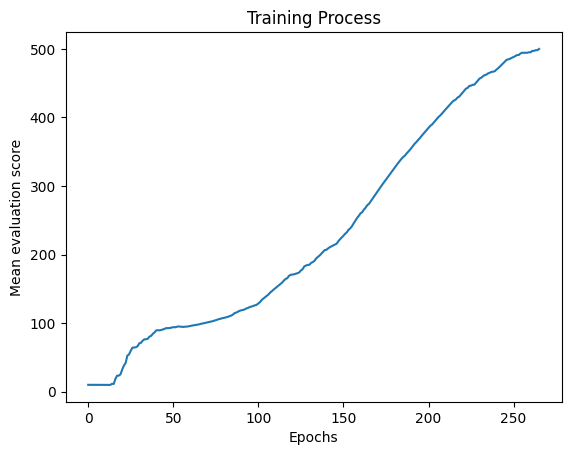

In [11]:
plt.plot(ddqn_agent.mean_evaluation_scores)
plt.xlabel("Epochs")
plt.ylabel("Mean evaluation score")
plt.title("Training Process")
plt.show()

In [12]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # select a seed value randomly
    seed = random.randint(0,20)

    # get the initial state
    state = env.reset(seed = seed)

    # for each timestep, do the following
    for t in range(500):
      # get the Q-value estimates
      q_values = model(state)
      # select the action (greedily)
      action = np.argmax(q_values.data.numpy())

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'ddqn_agent_cartpole.gif'), frames, duration=20)

In [13]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


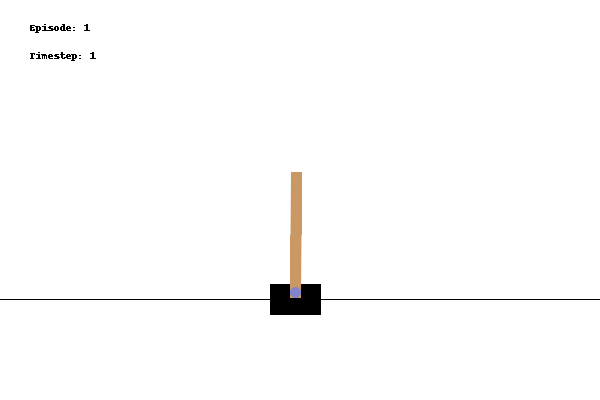

In [15]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/ddqn_agent_cartpole.gif','rb').read())